# Read in the data

In [2]:
import pandas as pd
import numpy as np 
from numpy import sqrt, abs, round
import re
import pdb
# Data Visualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey # data is a dict() defined in the above cell. 
data['hs_directory'].keys()

Index(['dbn', 'school_name', 'boro', 'building_code', 'phone_number',
       'fax_number', 'grade_span_min', 'grade_span_max', 'expgrade_span_min',
       'expgrade_span_max', 'bus', 'subway', 'primary_address_line_1', 'city',
       'state_code', 'zip', 'website', 'total_students', 'campus_name',
       'school_type', 'overview_paragraph', 'program_highlights',
       'language_classes', 'advancedplacement_courses', 'online_ap_courses',
       'online_language_courses', 'extracurricular_activities',
       'psal_sports_boys', 'psal_sports_girls', 'psal_sports_coed',
       'school_sports', 'partner_cbo', 'partner_hospital', 'partner_highered',
       'partner_cultural', 'partner_nonprofit', 'partner_corporate',
       'partner_financial', 'partner_other', 'addtl_info1', 'addtl_info2',
       'start_time', 'end_time', 'se_services', 'ell_programs',
       'school_accessibility_description', 'number_programs', 'priority01',
       'priority02', 'priority03', 'priority04', 'priority05', 

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"] # correlation of other features vs 'sat_score'
correlations

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

<AxesSubplot:>

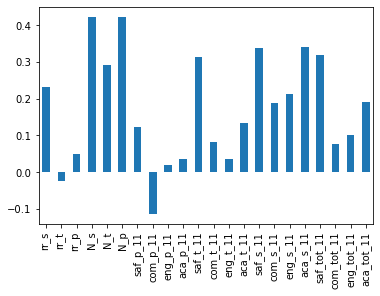

In [12]:
combined.corr()["sat_score"][survey_fields].plot.bar()

## Summary
Data dictionary is here: https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8
* N_s, N_t, and N_p all seem to have higher correlations with SAT score.
This makes sense since - since student, teacher, and parent respondents are indicative of enrollment and this can affect the SAT score.
* rr_s also has high correlation. Could be since response rate of a student may also indicate that the student studies hard.
* saf_s_ll, com_s_ll, eng_s_ll, aca_s_ll, and saf_tot_ll all have high correlation with SAT score.
Safety and community does help with studying and can be a factor for higher SAT scores.

In [13]:
def EDA_category(data, var_group):

    '''
    Univariate_Analysis_categorical
    takes a group of variables (category) and plot/print all the value_counts and barplot.
    '''
    # setting figure_size
    size = len(var_group)
    
    fig = plt.figure(figsize = (7*size,5), dpi = 100)
    fig.canvas.draw()
    plt.tight_layout(pad=1.08, h_pad=None, w_pad=100000, rect=None)

    # for every variable
    for i, col_name in enumerate(var_group):
        
        # Plotting the variable with every information
        plt.subplot(1,size,i+1)
        
        # from IPython import embed; embed()
        ax = sns.countplot(x=col_name, data=data, orient = 'h')        
        
        plt.xlabel('{}'.format(col_name), fontsize = 12)
    
        ncount = data.shape[0] - pd.isnull(data[col_name]).sum()
        
        # Make twin axis
        ax2=ax.twinx()

        # Switch so count axis is on right, frequency on left
        ax2.yaxis.tick_left()
        ax.yaxis.tick_right()

        # Also switch the labels over
        ax.yaxis.set_label_position('right')
        ax2.yaxis.set_label_position('left')

        ax2.set_ylabel('Frequency [%]')

        for p in ax.patches:
            x=p.get_bbox().get_points()[:,0]
            y=p.get_bbox().get_points()[1,1]
            ax.annotate('{:.1f}'.format(100.*y/ncount), (x.mean(), y), 
                    ha='center', va='bottom') # set the alignment of the text

        # Use a LinearLocator to ensure the correct number of ticks
        ax.yaxis.set_major_locator(ticker.LinearLocator(11))

        # Fix the frequency range to 0-100
        ax2.set_ylim(0,100)
        ax.set_ylim(0,ncount)

        # And use a MultipleLocator to ensure a tick spacing of 10
        ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

        # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
        ax2.grid(alpha = 0.1)

        plt.show

# custom function for easy and efficient analysis of numerical univariate
def EDA_numeric(data, var_group, log = False):
    
    size = len(var_group)
    plt.figure(figsize = (7*size,3), dpi = 100)
      #looping for each variable
    for j,i in enumerate(var_group):

        # calculating descriptives of variable
        mini = data[i].min()
        maxi = data[i].max()
        mean = data[i].mean()
        median = data[i].median()
        st_dev = data[i].std()
       # calculating points of one standard deviation
        points = mean-st_dev, mean+st_dev

        #Plotting the variable with every information
        plt.subplot(1,size,j+1)
        ax = sns.kdeplot(data[i], shade=True)
        
        if log == True:
            ax.set_xscale('log')
        else:
            pass

        plt.xlabel('{}'.format(i), fontsize = 13)
        plt.ylabel('density')
        plt.title('std_dev = {};range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                       
                                                                                                       (round(mini,2),round(maxi,2)),
                                                                                                       round(mean,2),
                                                                                                       round(median,2)))

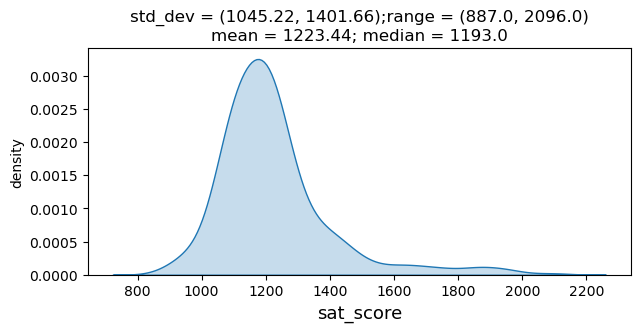

In [14]:
# univariate analysis of safety feature variable with SAT score.
EDA_numeric(combined, ['sat_score'])

Right skewed distribution with some outlier students scoring ont he very high end.

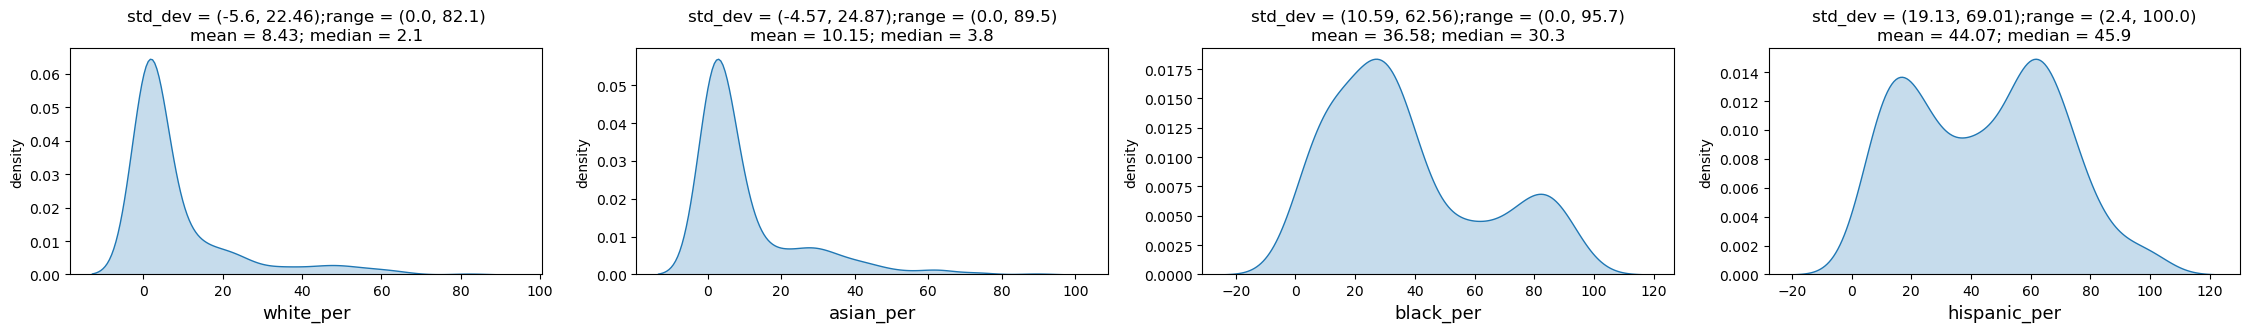

In [15]:
EDA_numeric(combined, ["white_per", "asian_per", "black_per", "hispanic_per"])

Above Distribution of white, asian, black, and hispanic students.

Summary, whites and asians tend to score better on the SAT compared to blacks and hispanics.

<AxesSubplot:xlabel='white_per', ylabel='sat_score'>

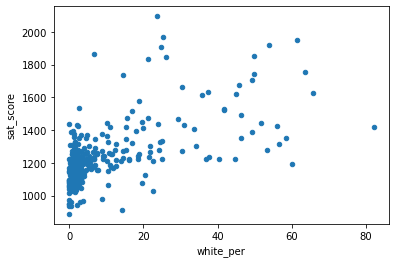

In [16]:
combined.plot.scatter("white_per", "sat_score")

<AxesSubplot:xlabel='asian_per', ylabel='sat_score'>

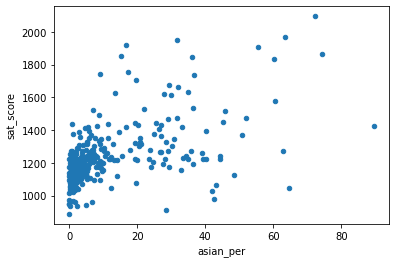

In [17]:
combined.plot.scatter("asian_per", "sat_score")

<AxesSubplot:xlabel='black_per', ylabel='sat_score'>

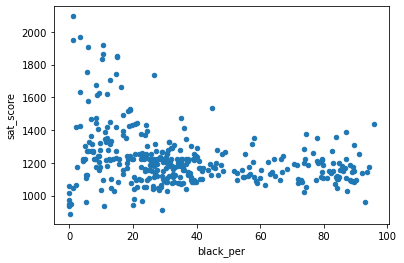

In [18]:
combined.plot.scatter("black_per", "sat_score")

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

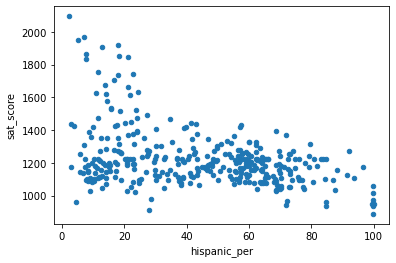

In [19]:
combined.plot.scatter("hispanic_per", "sat_score")

## Investigate Safety Scores
From above correlation plots we recall that safety does have a positive correlation with that of sat_score. Let's further investigate this.

<AxesSubplot:xlabel='saf_s_11', ylabel='sat_score'>

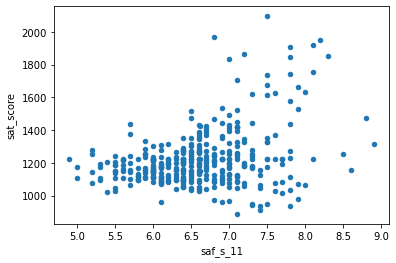

In [20]:
combined.plot.scatter('saf_s_11', 'sat_score')

We can see that the higher the safety score based on student responses, the higher the sat_score. However, there is not a significantly strong pattern here, i.e. extremely linear.

In [21]:
# compute saftey scores
combined.groupby('boro').mean()['saf_s_11']

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

For the most part, all boroughs (town or district) have comparable safety scores, but

## Investigate racial differences in SAT score

<AxesSubplot:>

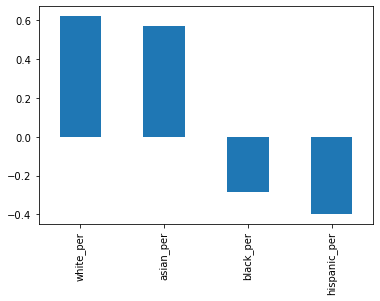

In [22]:
# racial performances
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()
# combined.corr()["sat_score"][race_fields]

White and Asian percentages score higher on the SAT than Blacks and Hispanics

## Research any schools with a hispanic_per > 95%

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

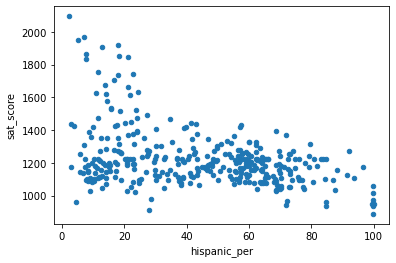

In [23]:
combined.plot.scatter("hispanic_per", "sat_score")

If school has > 95% hispanic percentage, SAT scores are 1000 and below.

In [24]:
combined.loc[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Manhattan Bridge High School
https://www.schools.nyc.gov/schools/M542
e.g. above is website for hispanic speaking students? Perhaps, English as a second language may be the reason for lower SAT scores, particularly on the written and verbal sections.

In [25]:
combined.loc[combined['hispanic_per'] < 95]['SCHOOL NAME']

0          HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES
1                    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL
2                             EAST SIDE COMMUNITY SCHOOL
3                                MARTA VALLE HIGH SCHOOL
4      NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...
                             ...                        
358          EBC HIGH SCHOOL FOR PUBLIC SERVICE–BUSHWICK
359                   BUSHWICK SCHOOL FOR SOCIAL JUSTICE
360                            ACADEMY OF URBAN PLANNING
361                 ALL CITY LEADERSHIP SECONDARY SCHOOL
362    BUSHWICK LEADERS HIGH SCHOOL FOR ACADEMIC EXCE...
Name: SCHOOL NAME, Length: 355, dtype: object

Above schools are probably STEM and better funded schools.

## Investigate Gender differences in SAT scores

<AxesSubplot:>

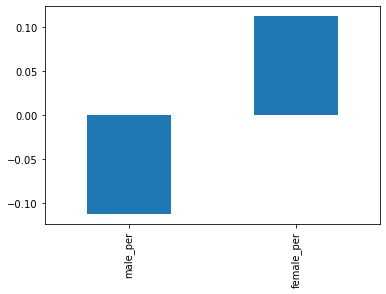

In [26]:
# gender performances
race_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

For both Males and Females the correlation is only 0.1. However, there is evidence that for schools with higher percenatge of females, SAT scores are higher.

<AxesSubplot:xlabel='female_per', ylabel='sat_score'>

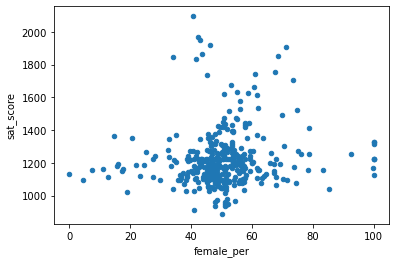

In [27]:
combined.plot.scatter('female_per', 'sat_score')

No real pattern here.

In [28]:
# combined.loc[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
combined.loc[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Most likely schools in high priced boroughs and high school ratings.

## Advanced Placement (AP) exams

<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

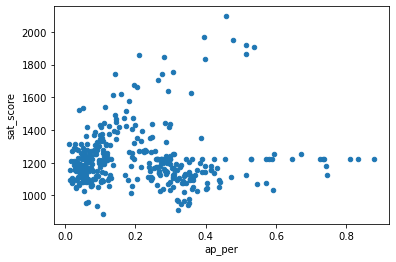

In [34]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')

Summary, we can see a correlation(though not signficantly strong) with AP students scoring higher in the SATs